# StarGuide Reconstruction

This tutorial demonstrates how to reconstruct Tc-99m phantom data collected using a StarGuide SPECT system. It should be noted that while the techniques here can be applied to higher energy isotopes as well, the PSF model may not be sufficient due to pronounced septal penetration in the collimator.

In [1]:
import pydicom
import matplotlib.pyplot as plt
import os
import numpy as np
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.io.SPECT import dicom
from pytomography.algorithms import OSEM
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.projectors.SPECT import StarGuideSystemMatrix

In [2]:
PATH = '/disk1/pytomography_tutorial_data/'

Get the file paths of the 12 projection DICOM files (each corresponding to one head on the StarGuide system)

In [3]:
path_NM = os.path.join(PATH, 'starguide', 'NM_files')
files_NM = [os.path.join(path_NM, f) for f in os.listdir(path_NM)][:12]

Get metadata and projection data

In [4]:
object_meta, proj_meta = dicom.get_starguide_metadata(files_NM, nearest_theta=0.1)
projections = dicom.get_starguide_projections(files_NM)
print(projections.shape)

torch.Size([2, 2575, 16, 112])


Note that there are two energy windows (140.5keV for Tc-99m as well as a lower scatter window) and 2575 different projections (the StarGuide heads move continuously but data is still discretely binned),

Now we'll get the attenuation map / transform used for attenuation correction

In [5]:
path_CT = os.path.join(PATH, 'starguide', 'CT_files')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
attenuation_map = dicom.get_starguide_attenuation_map_from_CT_slices(files_CT, files_NM, index_peak=0)
attenuation_transform = SPECTAttenuationTransform(attenuation_map, assume_padded = False)

Get the PSF transform used for PSF modeling

In [ ]:
psf_meta = dicom.get_psfmeta_from_scanner_params(
    'G8-LEHR', # According the the header, these are the collimator parameters
    energy_keV=140.5, # Imaging of Tc-99m
    material='tungsten', # It is known that this is the material
    shape = 'square', # collimator hole shape
)
psf_transform = SPECTPSFTransform(psf_meta, assume_padded=False)

Build the system matrix

In [34]:
system_matrix = StarGuideSystemMatrix(
    object_meta=object_meta,
    proj_meta=proj_meta,
    obj2obj_transforms=[attenuation_transform, psf_transform],
    proj2proj_transforms=[]
)

Get photopeak / scatter for the likelihood:

In [35]:
photopeak = projections[0]
scatter = dicom.get_energy_window_scatter_estimate_projections(
    files_NM[0],
    projections,
    index_peak=0,
    index_lower=1
)

Define the likelihood and reconstruct with OSEM for 10 iteration and 10 subsets

In [36]:
likelihood = PoissonLogLikelihood(system_matrix, photopeak, additive_term=scatter)
reconstruction_algorithm = OSEM(likelihood)
recon_pytomography = reconstruction_algorithm(n_iters=10, n_subsets=10)

Compare to vendor

In [37]:
ds_recon = pydicom.dcmread(os.path.join(PATH, 'starguide', 'vendor_recon', 'i196884.NMDC.1'))
recon_vendor = ds_recon.pixel_array * ds_recon[0x0011,0x103b].value
recon_vendor = np.transpose(recon_vendor, (2,1,0))

Plot

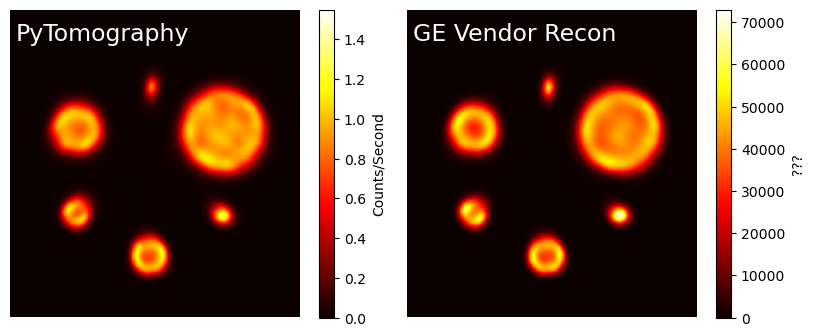

In [39]:
slc = 72
fig, ax = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace': 0.05})
plt.subplot(121)
plt.imshow(recon_pytomography[:,:,slc].cpu().T , vmax=1.55, cmap='hot', interpolation='gaussian')
plt.xlim(60,140)
plt.ylim(40,125)
plt.text(0.02, 0.9, 'PyTomography', color='white', fontsize=17, transform=ax[0].transAxes)
plt.colorbar(label='Counts/Second')
plt.axis('off')
plt.subplot(122)
plt.imshow(recon_vendor[:,:,slc].T, vmax=73000, cmap='hot', interpolation='gaussian')
plt.xlim(60,140)
plt.ylim(40,125)
plt.axis('off')
plt.text(0.02, 0.9, 'GE Vendor Recon', color='white', fontsize=17, transform=ax[1].transAxes)
plt.colorbar(label='???')
plt.show()

The two images are the same, but I have no idea what units GE is using for their reconstructed image...